In [1]:
import numpy as np
from matplotlib import pyplot as plt
import ctypes
import math
from scipy.integrate import solve_ivp, odeint
#Load aux shared library
clib = ctypes.CDLL('./lib/auxlib.so')

#Define the shared library functions signature
clib.henon_attractor.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float,
                                 ctypes.c_float, ctypes.c_float, ctypes.c_float, ctypes.c_float,
                                 ctypes.c_int]
clib.henon_attractor.restype = ctypes.POINTER(ctypes.c_float)

clib.classif_by_attractor_light.argtypes = [ctypes.c_double, ctypes.c_double]
clib.classif_by_attractor_light.restype = ctypes.c_int

# Atratores caóticos

<p> O artigo "Chaos, Strange Attractors, and Fractal Basin Boundaries in Nonlinear Dynamics", de Grebogi, Ott e Yorke, apresenta diversos conceitos e resultados importantes para o estudo de sistemas dinâmicos caóticos. Esse trabalho apresentará os principais pontos desse artigo e replicará os gráficos que foram utilizados para exemplificar conceitos e resultados.
</p>

<p> Primeiramente, o <en>paper</en> apresenta alguns conceitos iniciais, tais como o atrator, o atrator estranho, ou seja, atratores com formas fractais, e dimensão, definida no artigo como sendo a dimensão de <en>counting boxes</en>. A seguir, mostra-se o atrator caótico do mapa de Henón (para a = 1.4 e b = 0.3)
</p>

In [40]:
def henon_attractor(a, b, xmin, xmax, ymin, ymax, ndisc, niter):
    henon_map = lambda x, y: (a-x**2+b*y, x)
    x = y = 0.0

    for _ in range(ndisc):
        x, y = henon_map(x, y)

    X = []
    Y = []
    # A função clib.henon_attractor faz o cálculo de 10000 em 10000 para evitar Stack Overflow
    for i in range(math.ceil(niter/10000.0)):
        c_niter = min(10000, niter-i*10000)
        result = clib.henon_attractor(a, b, x, y, xmin, xmax, ymin, ymax, c_niter)
        orbit = ctypes.cast(result, ctypes.POINTER(ctypes.c_float * (2 * c_niter)))
        X += orbit[0][:c_niter]
        Y += orbit[0][c_niter:]
        x = X[-1]
        y = Y[-1]
    
    return np.array(X), np.array(Y)

Xa, Ya = henon_attractor(1.4, 0.3, -2, 2, -2, 2, 100, 10000)
Xb, Yb = henon_attractor(1.4, 0.3, 0.8, 1.1, 0.7, 0.95, 100, 10000)
Xc, Yc = henon_attractor(1.4, 0.3, 0.93, 0.965, 0.84, 0.875, 100, 10000)

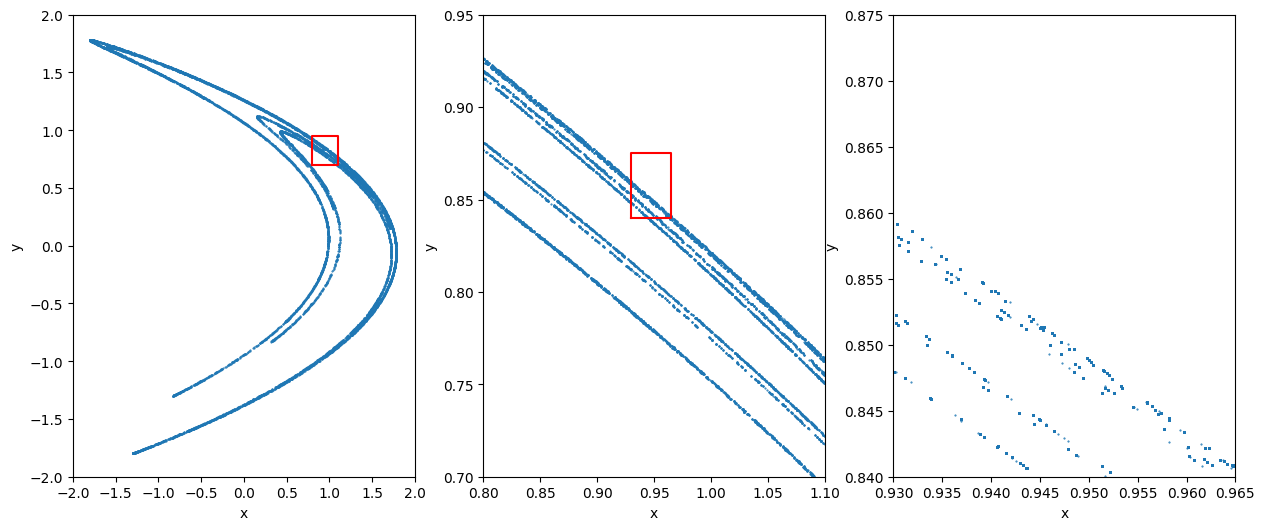

In [41]:
_, axs = plt.subplots(1,3, figsize = (15, 6), squeeze=False)

ax = axs[0][0]
ax.scatter(Xa, Ya, marker = '.', s = 1)
ax.plot([0.8, 0.8, 1.1, 1.1, 0.8], [0.7, 0.95, 0.95, 0.7, 0.7], color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

ax = axs[0][1]
ax.scatter(Xb, Yb, marker = '.', s = 1)
ax.plot([0.93, 0.93, 0.965, 0.965, 0.93], [0.84, 0.875, 0.875, 0.84, 0.84], color = 'r')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.8,1.1)
ax.set_ylim(0.7,0.95)

ax = axs[0][2]
ax.scatter(Xc, Yc, marker = '.', s = 1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(0.93,0.965)
ax.set_ylim(0.84,0.875)
plt.show()

Percebe-se que o atrator tem formato fractal, de modo que independentemente do zoom dado na imagem os padrões de linhas estarão presentes. Os atratores caóticos também são vistos para o pêndulo amortecido forçado periodicamente, cujo movimento é determinado pela EDO:

$$
\frac{d^2\theta}{dt^2} + \frac{0.22d\theta}{dt} + \sin{\theta} = 2.7\cos{t}
$$

Se considerarmos o mapa obtido ao considerar os tempos $t = 2k\pi$ temos a figura a seguir.

In [ ]:
def pendulum_ODE(t, y, v, f):
    theta, theta_ = y
    dtheta_dt = theta_
    dtheta_dt_2 = -v*theta_ - np.sin(theta) + f*np.cos(t)
    return[dtheta_dt, dtheta_dt_2]

t_points = np.arange(0, 100000, 2*np.pi)
initial_conditions = [0, 0]
t_span = (0, t_points[-1])


v = 0.22
f = 2.7

solver = solve_ivp(pendulum_ODE, t_span, initial_conditions, dense_output=True, args=(v,f), method='DOP853', max_step = 0.2)

solution = solver.sol(t_points)
theta_values = np.array(solution[0])
theta_values = np.mod(theta_values, 2*np.pi)
theta_values = np.where(theta_values > np.pi, theta_values-2*np.pi, theta_values)

dtheta_values = solution[1]

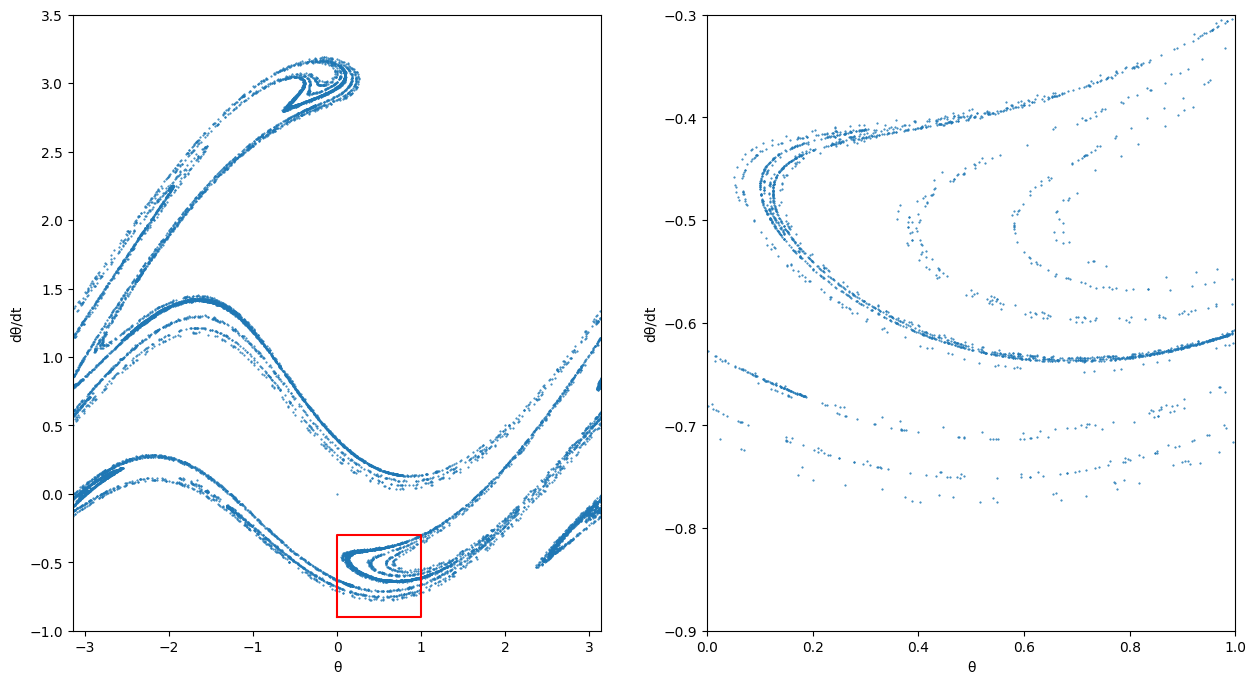

In [ ]:
fig, axs = plt.subplots(1,2, squeeze=False, figsize = (15,8))

ax = axs[0][0]
ax.scatter(theta_values, dtheta_values, s = 1, marker = ".")
ax.plot([0,0,1,1,0], [-0.9, -0.3, -0.3, -0.9, -0.9], color = 'r')
ax.set_xlim(-np.pi,np.pi)
ax.set_ylim(-1,3.5)
ax.set_xlabel('θ')
ax.set_ylabel('dθ/dt')

ax = axs[0][1]
ax.scatter(theta_values, dtheta_values, s = 1, marker = ".")
ax.set_xlim(0,1)
ax.set_ylim(-0.9,-0.3)
ax.set_xlabel('θ')
ax.set_ylabel('dθ/dt')

plt.show()

Além disso, ao plotar a velocidade angular pelo tempo, percebe-se o comportamento caótico dessa velocidade angular.

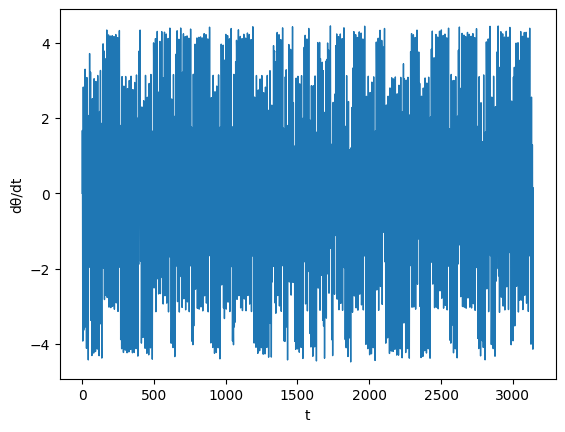

In [ ]:
t = np.linspace(0, 1000*np.pi, 10000)
dtheta = solver.sol(t)[1]
_, ax = plt.subplots()
ax.plot(t, dtheta, '-', linewidth = 1)
ax.set_xlabel("t")
ax.set_ylabel('dθ/dt')
plt.show()

Em geral, a forma dos atratores caóticos variam bastante ao alterar os parâmetros de um sistema dinâmico. Um exemplo é demonstrado com o seguinte mapa:

$$
\phi_{n+1} = [\phi_n + \omega_{1} + \epsilon P_1(\phi_n, \theta_n)]\text{   mod 1}
$$

$$
\theta_{n+1} = [\theta_n + \omega_{2} + \epsilon P_2(\phi_n, \theta_n)]\text{   mod 1}
$$

No qual $P_1$ e $P_2$ são funções periódicas de período 1. Os gráficos de $\phi$ por $\theta$ para diferentes parâmetros $\omega_1$, $\omega_2$ e $\epsilon$ são apresentados a seguir. O artigo não forneceu as funções $P_1$ e $P_2$, de modo que não foi possível replicar o mesmo gráfico do livro. Ainda assim é possível observar a variação do atratos caótico.


In [ ]:
# Function P was not given
P = lambda phi, theta: np.sin(2*np.pi*(phi))*np.cos(2*np.pi*theta+1)

def iterate_torus(w1, w2, eps, ndisc, niter):
    def iterate(phi, theta):
        result = np.array([phi+w1, theta+w2]) + eps*P(phi, theta)
        return np.mod(result, 1) 
    
    grid = np.zeros((1000, 1000))
    
    phi, theta = 0, 0
    for _ in range(ndisc):
        phi, theta = iterate(phi, theta)

    for _ in range(niter):
        phi, theta = iterate(phi, theta)
        grid[int(phi*1000)][int(theta*1000)] = 1

    return grid

grid_a = iterate_torus(0.54657, 0.36736, 0.75, 100, 100000)
grid_b = iterate_torus(0.45922, 0.53968, 0.50, 100, 100000)
grid_c = iterate_torus(0.41500, 0.73500, 0.60, 100, 100000)

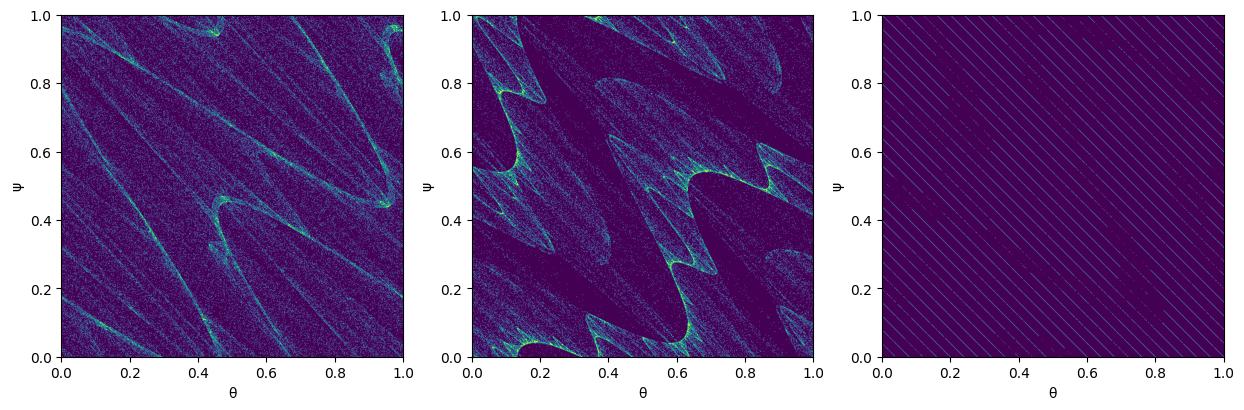

In [ ]:
fig, axs = plt.subplots(1,3, squeeze=False, figsize = (15,6))

ax = axs[0][0]
ax.imshow(grid_a, extent = [0, 1, 0, 1])
ax.set_xlabel('θ')
ax.set_ylabel('ψ')

ax = axs[0][1]
ax.imshow(grid_b, extent = [0, 1, 0, 1])
ax.set_xlabel('θ')
ax.set_ylabel('ψ')

ax = axs[0][2]
ax.imshow(grid_c, extent = [0, 1, 0, 1])
ax.set_xlabel('θ')
ax.set_ylabel('ψ')

plt.show()


O primeiro plot (à esquerda) utilizou $\omega_1=0.54657$, $\omega_2=0.36736$ e $\epsilon=0.75$. Para o segundo plot, $\omega_1=0.45922$, $\omega_2=0.53968$ e $\epsilon=0.50$. Por fim, o último plot utilizou $\omega_1=0.41500$, $\omega_2=0.73500$ e $\epsilon=0.60$. Perceba que nesse último caso o atrator perdeu o caráter caótico ao variar o parâmetro.

# A evolução dos atratores caóticos

Em sistemas dissipativos, é comum que para alguns parâmetros haja um atrator não-caótico (como no último gráfico do exemplo anterior), enquanto que para outros valores o atrator seja caótico. Agora será estudado como  atrator varia quando um parâmetro do sistema dinâmico é variado continuamente. Vamos estudar com base no mapa quadrático $x_{n+1}=g(x_n)=C-x_n^2$. A seguir, está representado o diagrama de bifurcação desse mapa.

In [2]:
def get_periodic_points(f, x0, n_discard, n_iter, n_digits):
    """
    params
    function f: map to be applied
    float x0: initial point
    n_discard: the amount of first iterations that will be discarted
    n_iter: the amount of points that will be collected after the discard
    n_digits: number of decimals to be rounded into

    output
    list: periodic points for the given function
    """

    #iterate n_discard times
    for _ in range(n_discard):
        x0 = f(x0)
        if abs(x0) > 100:
            return None

    #iterate n_iter times and save values in a dict (faster than list for searching keys)
    y = dict()
    for _ in range(n_iter):
        x0 = f(x0)
        if abs(x0) > 100:
            return None
        rounded = round(x0, n_digits)
        if rounded in y:
            return y.keys()
        y[rounded] = True

    return y.keys()

def quadratic_map(c):
    return lambda x: c - x**2

def bifurcation_map(f_getter, x0, start, end, n_discard, n_iter, n_digits):
    X_plot = list()
    Y_plot = list()
    C = np.linspace(start, end, 5000)
    for c in C:
        y = get_periodic_points(f_getter(c), x0, n_discard, n_iter, n_digits)
        if y != None:
            Y_plot += y
            X_plot += [c for i in range(len(y))]
    return X_plot, Y_plot

Xa, Ya = bifurcation_map(quadratic_map, 0, -0.4, 2.1, 2000, 2000, 5)
Xb, Yb = bifurcation_map(quadratic_map, 0, 1.72, 1.82, 2000, 2000, 5)

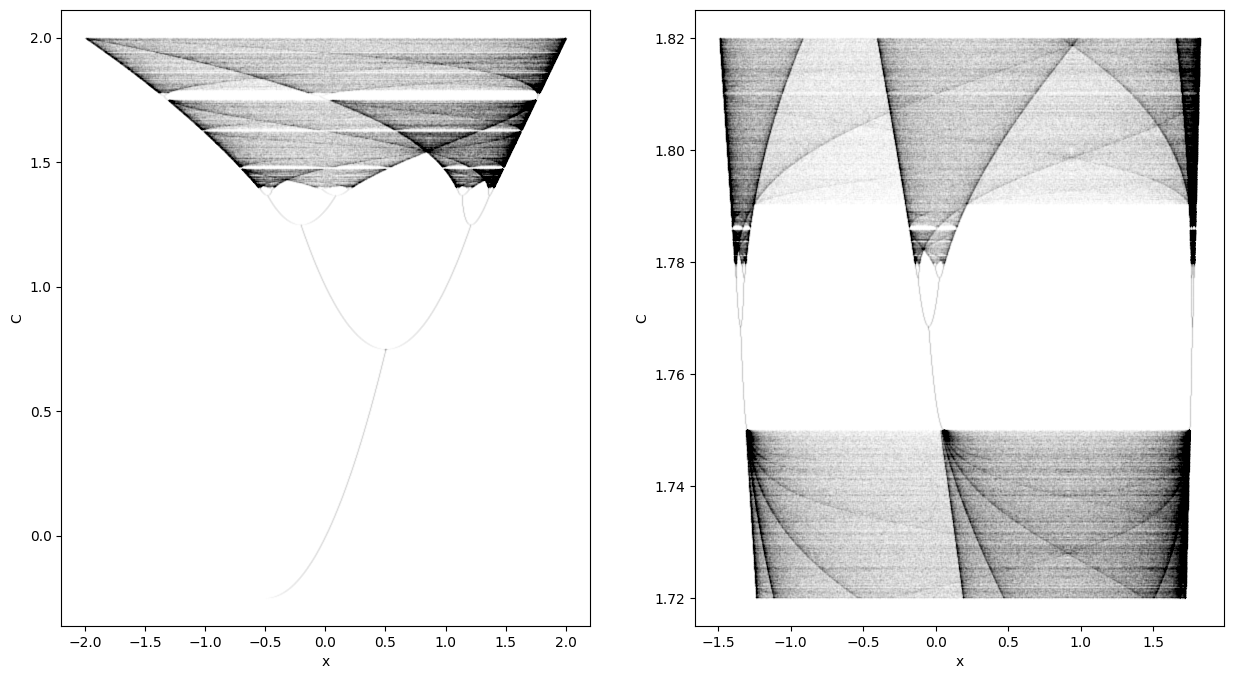

In [ ]:
_, axs = plt.subplots(1, 2, squeeze = False, figsize = (15, 8))
ax = axs[0][0]
ax.scatter(Ya, Xa, s = 1, marker = ".", color = 'k', alpha = 0.01)
ax.set_xlabel('x')
ax.set_ylabel('C')
ax = axs[0][1]
ax.scatter(Yb, Xb, s = 1, marker = ".", color = 'k', alpha = 0.01)
ax.set_xlabel('x')
ax.set_ylabel('C')
plt.show()

Pela figura acima, pode-se observar três das possíveis rotas para o caos. A primeira delas é a cascata de dobragem de período, na qual a órbita não-caótica se bifurca em intervalos de $x$ cada vez menores até se tornar caótica. Além disso, pode-se observar o fenômeno da intermitência, ou bifurcação tangente, quando a órbita caótica passa a ter período 3 quando a equação $g^3(x) = x$ passa a ter solução. 

Por fim, percebe-se se também que a partir de $C = 2$ deixa de existir um atrator caótico no sistema. Isso exemplifica a rota para o caos por meio de crises. Nessa crise, a órbita segue um caminho caótico, chamado de transiente caótico, por um número finito de iterações até divergir para $-\infty$. À medida em que $C$ se afasta de $2$, o transiente caótico diminui, sendo que a duração média para o mapa quadrático é dada por:

$$
\tau \approx \frac{1}{(C-C_C)^{\frac{1}{2}}}
$$

Tais rotas para o caos também ocorrem para sistemas de tempo contínuo. Para exemplificar, a seguir analisaremos o sistema de EDOs estudados por Lorenz.

$$
\frac{dx}{dt} = Py-Px
$$
$$
\frac{dy}{dt} = -xz+rx-y
$$
$$
\frac{dz}{dt} = xy-bz
$$

Fixando $P=10$ e $b=8/3$ e variando o parâmetro $r$, são obtidas soluções numéricas em que se pode analisar as rotas para o caos por intermitência e por crise.



In [43]:
def lorenz(t, s, P, b, r):

    x, y, z = s
    dx = P*y - P*x
    dy = -x*z + r*x - y
    dz = x*y - b*z
    
    return[dx, dy, dz]

initial_conditions = [1,1,1]
t_span = (0, 100)


P = 10.0
b = 8/3

solution_a = solve_ivp(lorenz, t_span, initial_conditions, dense_output=True, args=(P, b, 166.0), method='DOP853')
solution_b = solve_ivp(lorenz, t_span, initial_conditions, dense_output=True, args=(P, b, 166.2), method='DOP853')
solution_c = solve_ivp(lorenz, t_span, initial_conditions, dense_output=True, args=(P, b, 28), method='DOP853', max_step = 0.2)
solution_d = solve_ivp(lorenz, t_span, initial_conditions, dense_output=True, args=(P, b, 22), method='DOP853', max_step = 0.2)

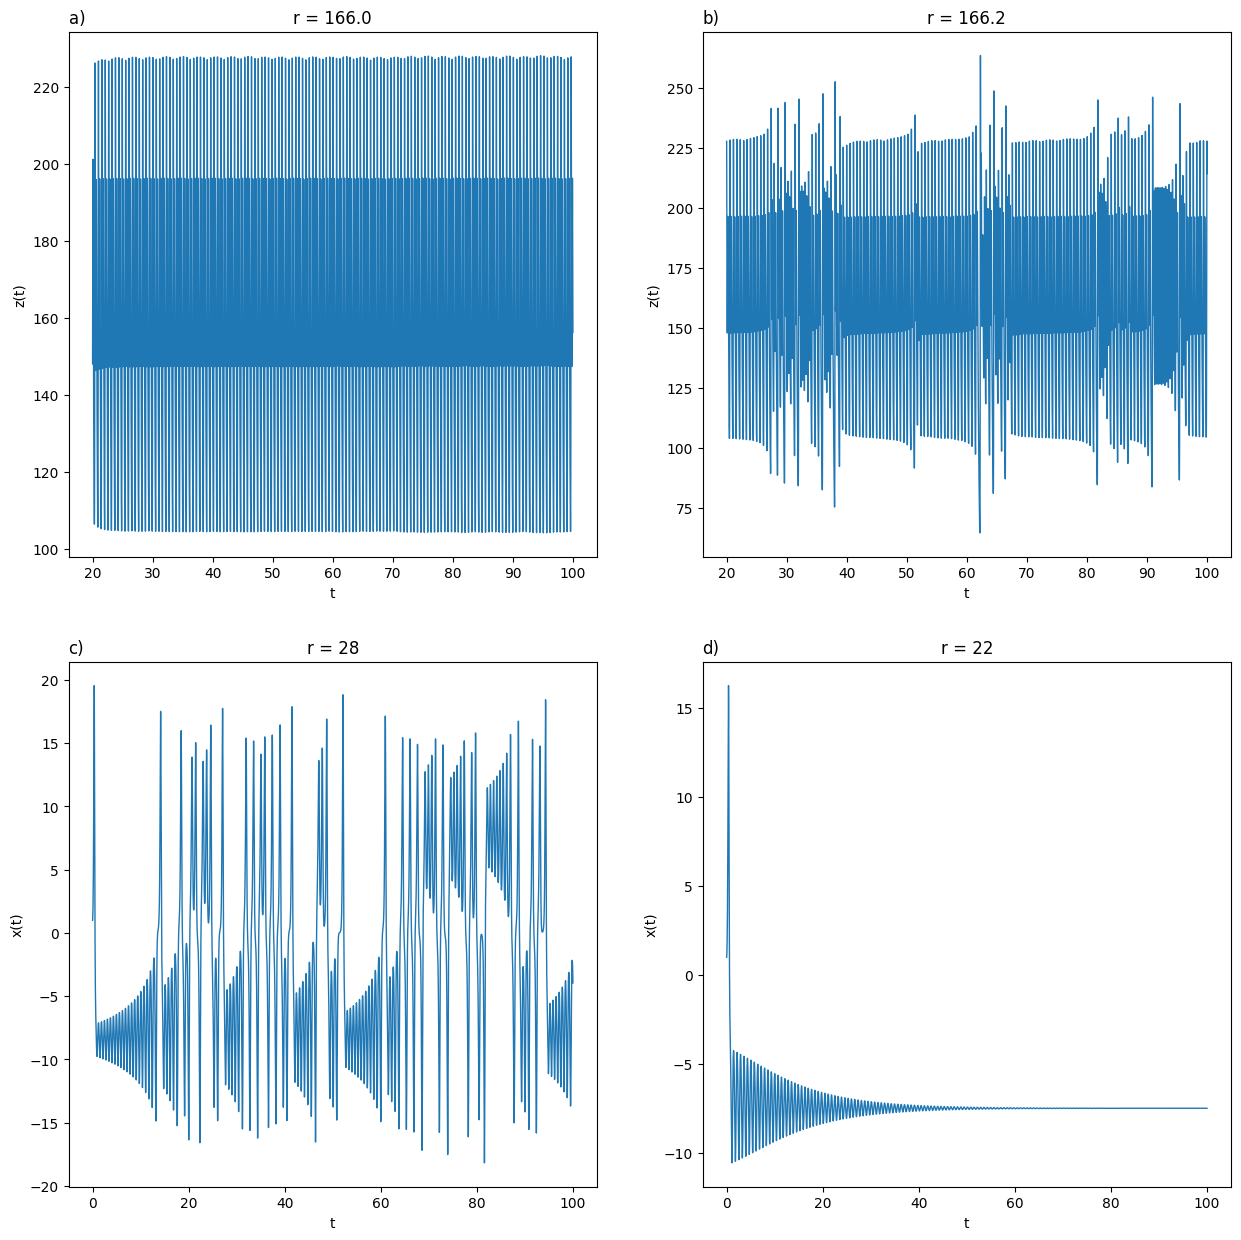

In [44]:
fig, axs = plt.subplots(2,2, figsize = (15,15))

ax = axs[0][0]
t = np.linspace(20, 100, 10000)
s = solution_a.sol(t)
ax.plot(t, s[2], linewidth = 1)
ax.set_xlabel('t')
ax.set_ylabel('z(t)')
ax.set_title('r = 166.0')
ax.set_title('a)', loc='left')

ax = axs[0][1]
t = np.linspace(20, 100, 10000)
s = solution_b.sol(t)
ax.plot(t, s[2], linewidth = 1)
ax.set_xlabel('t')
ax.set_ylabel('z(t)')
ax.set_title('r = 166.2')
ax.set_title('b)', loc='left')

ax = axs[1][0]
t = np.linspace(0, 100, 10000)
s = solution_c.sol(t)
ax.plot(t, s[0], linewidth = 1)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.set_title('r = 28')
ax.set_title('c)', loc='left')

ax = axs[1][1]
t = np.linspace(0, 100, 10000)
s = solution_d.sol(t)
ax.plot(t, s[0], linewidth = 1)
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.set_title('r = 22')
ax.set_title('d)', loc='left')

plt.show()

Para $r$ entre 166.0 e 166.2 há uma transição para o caos devido a uma intermitência, de modo que na figura a) $x(t)$ é periódico, enquanto que na figura b) é caótico. 
Além disso, para valores de $r$ menores que 24.06, existem dois atratores periódicos, sendo que um deles é apresentado na figura d). Porém, para valores acima de 24.06, há o surgimento de um atrator caótico, apresentado na figura c).

# Universalidade

O termo universalidade se refere ao fato de que sistemas se comportam quantitativamente de formas que não dependem do modelo particular, mas de propriedades gerais do sistema. Um exemplo de resultado "universal" pode ser obervado em diagramas de bifurcação para mapas unidimensionais. Seja $C_n$ o valor de $C$ para o qual um período de tamanho $2^n$ dobra e se torna de tamanho $2^{n+1}$. Então, independentemente do mapa unidimensional temos que:

$$
lim_{n\to\infty} \frac{C_n-C_{n-1}}{C_{n+1}-C_n} \approx 4.67
$$

Para verificar essa propriedades, calculamos numericamente o valor desse limite para os casos do mapa logístico $x_{n+1}=ax_n(1-x_n)$ e do mapa quadrático $x_{n+1}=C-x_n^2$.

In [3]:
def logistic_map(a):
    return lambda x: a*x*(1-x)

In [4]:
def find_bifurcation(f_getter, n_branch, x0, start, end, n_discard, n_iter, n_digits):
    C = np.linspace(start, end, 5000)
    for i in range(len(C)):
        y = get_periodic_points(f_getter(C[i]), x0, n_discard, n_iter, n_digits)
        if y != None:
            if len(y) >= 2*n_branch:
                return C[i-1], C[i]
    print(n_branch)
    print(start, end)
    raise ValueError

def get_bif_points(f_getter, n_max, precision, x0, start0, end0, n_discard, n_iter, n_digits):
    points = []
    n_branch = 1
    start, end = start0, end0
    while n_branch < 2**n_max:
        while end - start > precision:
            start, end = find_bifurcation(f_getter, n_branch, x0, start, end, n_discard, n_iter, n_digits)
        points.append(start)
        end = end0
        n_branch *= 2
    return [(points[i+1]-points[i])/(points[i+2]-points[i+1]) for i in range(len(points)-2)], points

In [5]:
quad_ratio, quad_points = get_bif_points(quadratic_map, 6, 0.00001, 0, 0, 1.42, 10000, 500, 5)

In [6]:
log_ratio, log_points = get_bif_points(logistic_map, 6, 0.00001, 0.2, 2.8, 3.6, 10000, 500, 5)

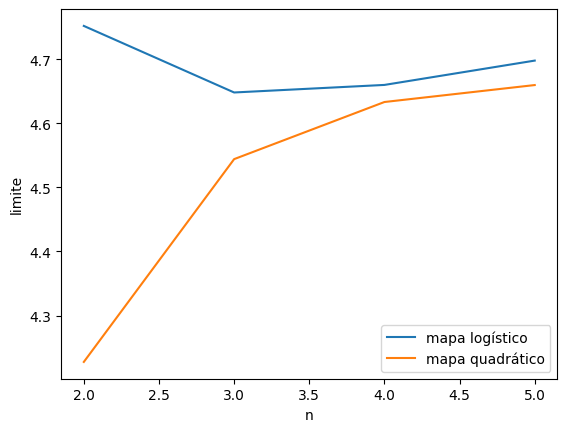

In [11]:
_, ax = plt.subplots()
n = [2,3,4,5]
ax.plot(n, log_ratio, label='mapa logístico')
ax.plot(n, quad_ratio, label='mapa quadrático')
ax.set_xlabel('n')
ax.set_ylabel('limite')
ax.legend()
plt.show()

Perceba que, apesar de haver alguns erros numéricos, o limite para n tendendo a infinito converge aproximadamente para 4.7 em ambos mapas.

Analisaremos também outra propriedade geral dos mapas unidimensionais, relacionada às janelas periódicas. Seja $C_0^{(k)}$ e $C_C^{(k)}$, respectivamente, os valores de parâmetro do mapa que limitam superiormente e inferiormente a janela periódica. Além disso, $C_d^{(k)}$ é o valor de parâmetro para o qual o atrator de período $k$ dobra para $2k$. Então, para valores de $k$ primos, temos que:

$$
lim_{n\to\infty} \frac{C_C^{(k)}-C_0^{(k)}}{C_d^{(k)}-C_0^{(k)}} = 2.25
$$

Vamos também verificar essa propriedade numericamente, tanto para o mapa quadrático (parâmetro $C$), quanto para o mapa logístico (parâmetro $a$).


In [12]:
def k_window_ratio(f_getter, k, x0, start0, end0, n_discard, n_iter, n_digits):
    c = np.linspace(start0, end0, 5000)
    find_k_periodic = True
    find_2k_periodic = True
    find_window_end = True
    i = 0
    c0 = cd = cc = 0
    while(find_k_periodic):
        y = get_periodic_points(f_getter(c[i]), x0, n_discard, n_iter, n_digits)
        if y != None:
            if len(y) == k:
                find_k_periodic = False
                c0 = c[i]
        i += 1
    while(find_2k_periodic):
        y = get_periodic_points(f_getter(c[i]), x0, n_discard, n_iter, n_digits)
        if y != None:
            if len(y) == 2*k:
                find_2k_periodic = False
                cd = c[i]
        i += 1

    while(find_window_end and i < 5000):
        y = get_periodic_points(f_getter(c[i]), x0, n_discard, n_iter, n_digits)
        test_counter = 0
        if y != None:
            test_points = np.linspace(min(y), max(y), 10)
            r = (max(y)-min(y))/20
            for p in range(len(test_points)):
                for point in y:
                    if abs(point - test_points[p]) < r:
                        test_counter += 1
                        break
                if test_counter != p + 1:
                    break
            if len(test_points) == test_counter:
                find_window_end = False
                cc = c[i]
        i += 1
    
    return c0, cd, cc
    

In [13]:
c0_quad_3, cd_quad_3, cc_quad_3 = k_window_ratio(quadratic_map, 3, 0, 1.749, 1.791, 10000, 10000, 5)

In [14]:
c0_log_3, cd_log_3, cc_log_3 = k_window_ratio(logistic_map, 3, 0.1, 3.82, 3.87, 10000, 10000, 5)

In [15]:
ratio_quad_3 = (cc_quad_3-c0_quad_3)/(cd_quad_3-c0_quad_3)
ratio_log_3 =  (cc_log_3-c0_log_3)/(cd_log_3-c0_log_3)

In [16]:
c0_quad_5, cd_quad_5, cc_quad_5 = k_window_ratio(quadratic_map, 5, 0, 1.5, 1.7, 10000, 10000, 5)
c0_log_5, cd_log_5, cc_log_5 = k_window_ratio(logistic_map, 5, 0.1, 3.7, 3.8, 10000, 10000, 5)

In [17]:
ratio_quad_5 = (cc_quad_5-c0_quad_5)/(cd_quad_5-c0_quad_5)
ratio_log_5 =  (cc_log_5-c0_log_5)/(cd_log_5-c0_log_5)

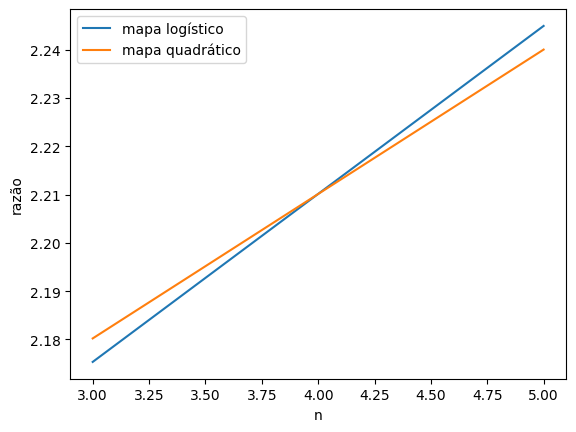

In [18]:
ratio_quad = [ratio_quad_3, ratio_quad_5]
ratio_log = [ratio_log_3, ratio_log_5]
n = [3,5]

_, ax = plt.subplots()
ax.plot(n, ratio_log, label='mapa logístico')
ax.plot(n, ratio_quad, label='mapa quadrático')
ax.set_xlabel('n')
ax.set_ylabel('razão')
ax.legend()
plt.show()


Mesmo para $k=5$, percebe-se que a razão dos pontos da janela periódica de ambos mapas unidimensionais se aproximam bem de $2.25$. Mais uma vez, então, observa-se uma propriedade universal de sistemas dinâmicos caóticos.

# Bacia de atração fractal

O último tópico abordado no artigo se trata das bacias de atração em formato fractal. Em alguns sistemas dinâmicos, há mais de um atrator, de modo que dependendo das condições iniciais a órbita tenderá a diferentes atratores. Um exemplo pode ser visto a partir da seguinte equação do pêndulo forçado periodicamente.

$$
\frac{d^2\theta}{dt^2} + \frac{0.2d\theta}{dt} + \sin{\theta} = 2.0\cos{t}
$$

Esse sistema tem dois pontos atratores: $(-0.477, -0.609)$ e $(-0.471, 2.037)$. Como apresentado na simulação a seguir, a bacia de atração desses pontos formam um fractal.

In [30]:
def attraction_grid(xmin, xmax, ymin, ymax, n_points=1000):
    x = np.linspace(xmin, xmax, n_points)
    y = np.linspace(ymin, ymax, n_points)
    vec_classifier = np.vectorize(lambda x0, y0: clib.classif_by_attractor_light(x0, y0))

    xv, yv = np.meshgrid(x, y)
    grid = vec_classifier(xv, yv)
    return grid

grid1 = attraction_grid(-np.pi, np.pi, -3, 3)

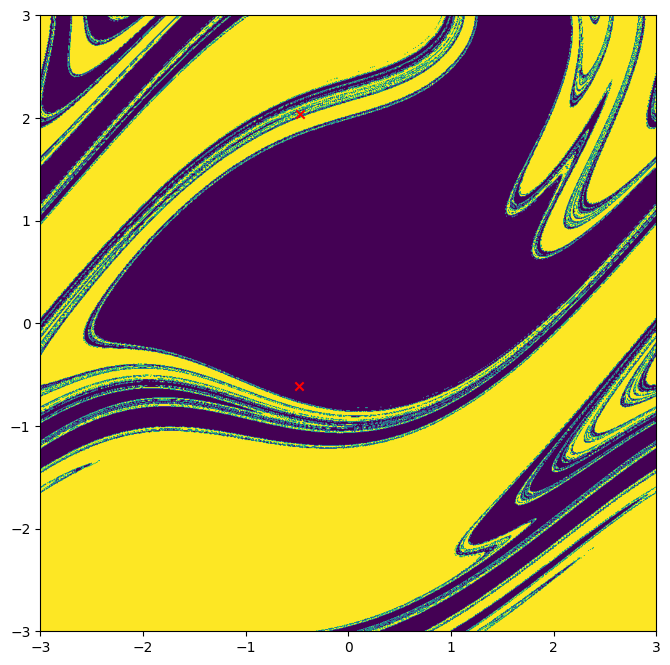

In [24]:
_, ax = plt.subplots(figsize = (8,8))
ax.imshow(grid1, extent=[-3, 3, -3, 3])
ax.scatter([-0.477, -0.471], [-0.609, 2.037], marker='x', color='r')
plt.show()

Para condições iniciais na região roxa, a órbita é atraída para $(-0.477, -0.609)$. Enquanto isso, órbitas com condições iniciais na região amarela são atraídas para $(-0.471, 2.037)$

In [40]:
grid2 = attraction_grid(-np.pi, np.pi, -3, 3, 500)
grid3 = attraction_grid(-np.pi, np.pi, -3, 3, 250)

In [56]:
def verify_boundary(grid:np.array, i, j):
    u = max(0, i-1)
    v = max(0, j-1)
    y,x = grid.shape

    while u <= min(i+1, y-1):
        while v <= min(j+1, x-1):
            if grid[u][v] == 0:
                return True
            v += 1
        u += 1
    return False

def count_boundary(grid:np.array):
    y,x = grid.shape
    count = 0

    for i in range(y):
        for j in range(x):
            if grid[i][j] == 1:
                if verify_boundary(grid, i, j):
                    count += 1
    return count

grids = [grid1, grid2, grid3]

log_Neps = []
log_1_eps = []
for grid in grids:
    log_Neps.append(np.log(count_boundary(grid)))
    
log_Neps = np.array(log_Neps)
log_1_eps = np.log(np.array([1000.0/6, 500.0/6, 250.0/6]))


In [58]:
#getting the slope using least squares
n = np.size(log_Neps)
m_x = np.mean(log_1_eps)
m_y = np.mean(log_Neps)
SS_xy = np.sum(log_Neps*log_1_eps) - n*m_x*m_y
SS_xx = np.sum(log_1_eps ** 2) - n*m_x**2
result = SS_xy/SS_xx

Calculando a dimensão fractal utilizando counting-boxes, obtém-se $d\approx1.67$, resultado levemente diferente do enontrado pelo artigo, $d=1.725$. Utilizando o resultado encontrado numericamente $d\approx1.67$, podemos calucular:

$$
\alpha=2-1.67=0.33
$$

Dessa forma, a fração $f$ dos pontos iniciais para os quais a órbita é incerta, dada uma incerteza $\epsilon$ no ponto inicial, é dada por:

$$
f ~ \epsilon^\alpha = \epsilon^{0.33}
$$

Então, para reduzir pela metade a incerteza de errar o ponto atrator, dada condição inicial, é necessário diminuir a incerteza $\epsilon$ da condição inicial em $2^{1/0.33}\approx8$. Conclui-se que fronteiras de bacia de atração fractais dificulta a previsão de órbitas em sistemas dinâmicos.